In [1]:
import os
import torch
from torch.utils.data import random_split, dataloader
from torchvision import datasets
from torchvision import transforms
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt

from kmnist_model import SimpleModel, BatchModel, DropoutModel, LeNetModel, ConvNetModel
from funcs import train, predict

In [2]:
def set_seed(seed: int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)

# Завантажую дані та ділю на train/val/test

In [4]:
train_data = datasets.KMNIST(
    root='data',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
    )

In [5]:
test_data = datasets.KMNIST(
    root='data',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
    )

In [6]:
train_size = int(0.85 * len(train_data))
valid_size = len(train_data) - train_size
train_data, valid_data = random_split(train_data, [train_size, valid_size])

In [7]:
image, label = train_data[0]
print(f"Data shape: {image.shape}")
print(f"Label: {label}")
print('Train:', len(train_data))
print('Valid:', len(valid_data))
print('Test:', len(test_data.data), len(test_data.targets))

Data shape: torch.Size([1, 28, 28])
Label: 7
Train: 51000
Valid: 9000
Test: 10000 10000


In [8]:
class_names = train_data.dataset.classes
print('Class names:', class_names)

Class names: ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


Image shape: torch.Size([1, 28, 28])


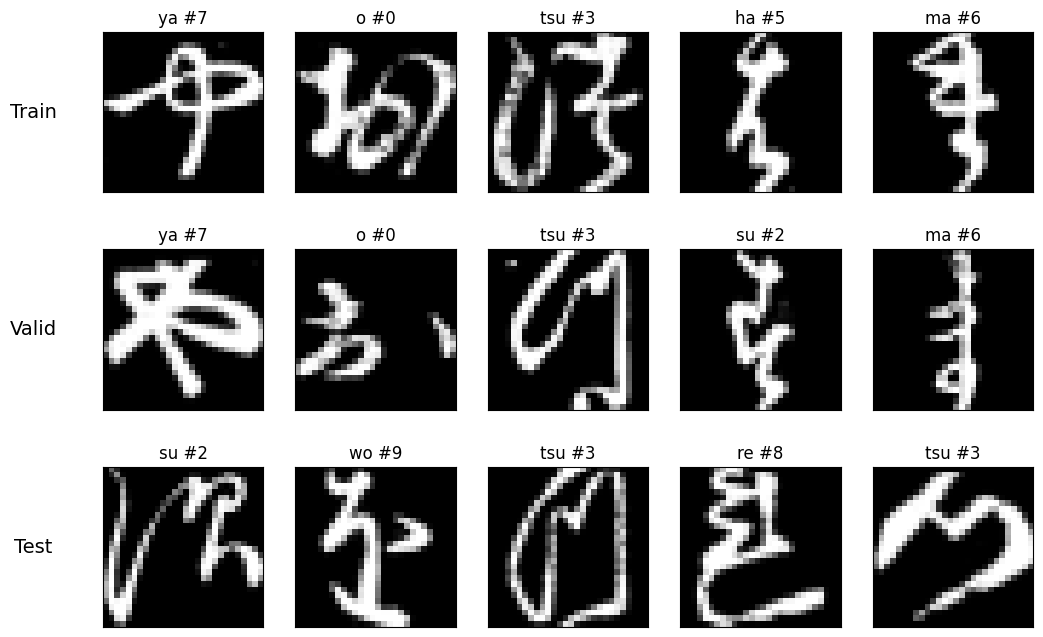

In [9]:
image, label = train_data[0]
print('Image shape:', image.shape)

fig, axs = plt.subplots(3, 5, figsize=(12, 8))
row_names = ['Train', 'Valid', 'Test']

for i, data in enumerate([train_data, valid_data, test_data]):
    for j in range(5):
        image, label = data[j]
        axs[i, j].imshow(image.squeeze(), cmap='gray')
        axs[i, j].set_title(f'{class_names[label]} #{label}')
        # прибере осі, але залишить підписи
        axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axs[i, 0].set_ylabel(row_names[i], fontsize=14, rotation=0, labelpad=50, va='center')
plt.show()

# Роблю розбиття на батчі

In [10]:
BATCH_SIZE = 32
train_dataloader = dataloader.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
)

valid_dataloader = dataloader.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count(),
    drop_last=True,
)

print(f"Length of Train dataloader: {len(train_dataloader)}")
print(f"Length of Valid dataloader: {len(valid_dataloader)}")

Length of Train dataloader: 1593
Length of Valid dataloader: 281


Train image batch shape: torch.Size([32, 1, 28, 28])
Train label batch shape: torch.Size([32])


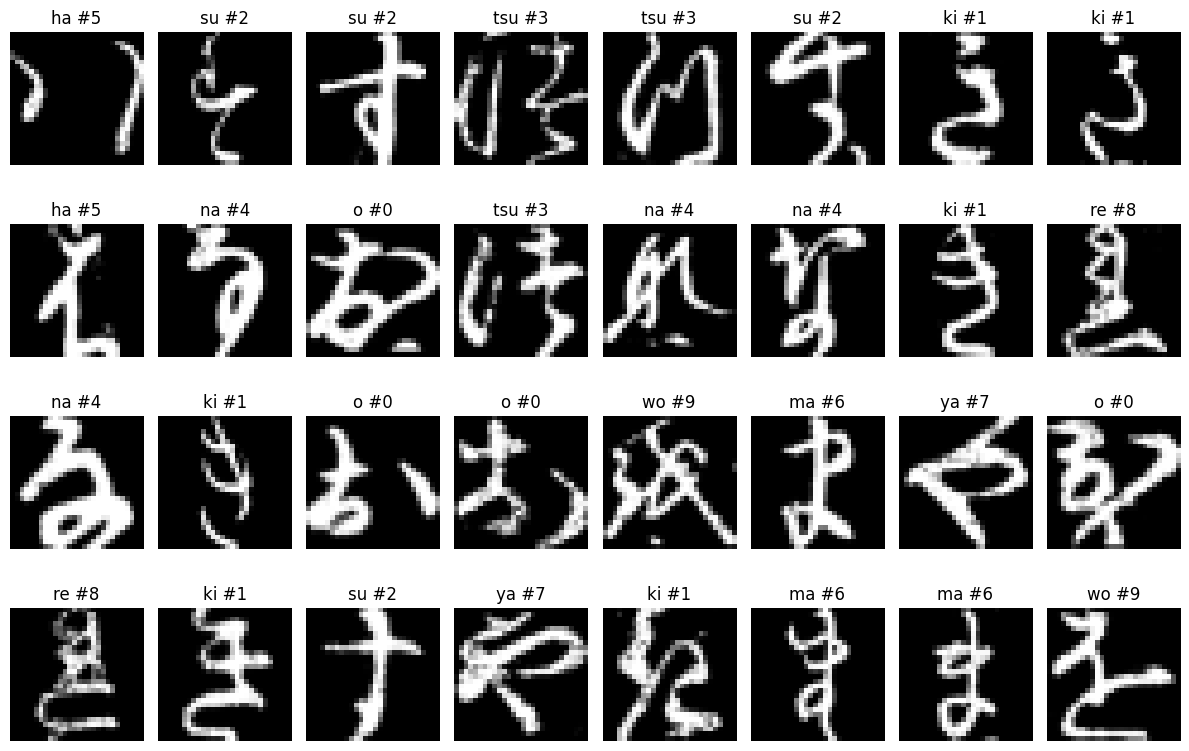

In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print('Train image batch shape:', train_features_batch.shape)
print('Train label batch shape:', train_labels_batch.shape)

count = train_features_batch.shape[0]
rows = 4
columns = count // rows

fig, axs = plt.subplots(rows, columns, figsize=(12, 8))
for idx in range(count):
    row = idx // columns
    col = idx % columns
    axs[row, col].imshow(train_features_batch[idx].squeeze(), cmap='gray')
    axs[row, col].set_title(f'{class_names[train_labels_batch[idx]]} #{train_labels_batch[idx]}')
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()

# Створюю згорточну модель та треную (файл kmnist_model.py, funcs.py)

## Simple model

In [12]:
simple_model = SimpleModel(input_channels=1, hidden_channels=10, output_shape=len(class_names)).to(device)
print(simple_model)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.005)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
epochs = 10

SimpleModel(
  (convolutional_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolutional_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
<class 'kmnist_model.SimpleModel'> Train loss: 1.1357, Train accuracy: 0.6218


Training:  10%|█         | 1/10 [00:50<07:35, 50.61s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.8983, Valid accuracy: 0.7083
Epoch 2/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.8206, Train accuracy: 0.7294


Training:  20%|██        | 2/10 [01:35<06:17, 47.19s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.7914, Valid accuracy: 0.7462
Epoch 3/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.7412, Train accuracy: 0.7636


Training:  30%|███       | 3/10 [02:19<05:21, 45.98s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.7413, Valid accuracy: 0.7585
Epoch 4/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6986, Train accuracy: 0.7726


Training:  40%|████      | 4/10 [03:13<04:53, 48.91s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.7335, Valid accuracy: 0.7644
Epoch 5/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6628, Train accuracy: 0.7838


Training:  50%|█████     | 5/10 [04:00<04:01, 48.31s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6872, Valid accuracy: 0.7736
Epoch 6/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6418, Train accuracy: 0.7912


Training:  60%|██████    | 6/10 [04:47<03:11, 47.87s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6917, Valid accuracy: 0.7737
Epoch 7/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6194, Train accuracy: 0.7974


Training:  70%|███████   | 7/10 [05:36<02:24, 48.33s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6295, Valid accuracy: 0.7923
Epoch 8/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6051, Train accuracy: 0.7991


Training:  80%|████████  | 8/10 [06:25<01:36, 48.40s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6272, Valid accuracy: 0.7936
Epoch 9/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.5853, Train accuracy: 0.8082


Training:  90%|█████████ | 9/10 [07:14<00:48, 48.51s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6267, Valid accuracy: 0.7962
Epoch 10/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.5724, Train accuracy: 0.8109


Training: 100%|██████████| 10/10 [08:12<00:00, 49.29s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6460, Valid accuracy: 0.7888
Total training time: 492.86 seconds


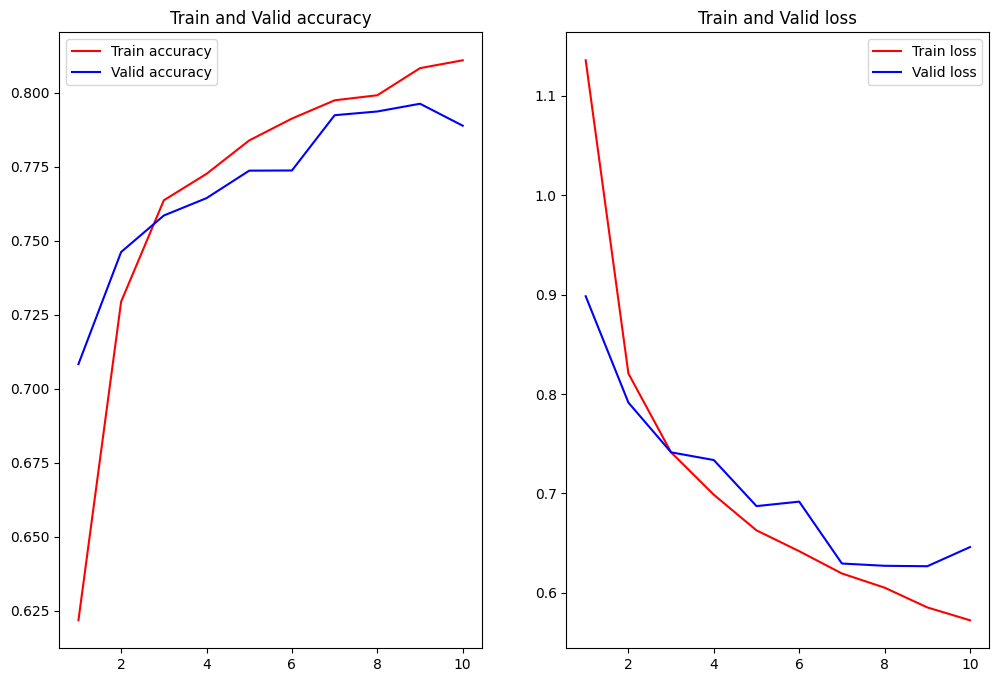

([1.1357161756850456,
  0.8205783474355544,
  0.7412445509837846,
  0.6986482665083054,
  0.6628022508021053,
  0.6418357959761982,
  0.619424094803215,
  0.6051498110366931,
  0.5852852729473634,
  0.5723507594964973],
 [0.6218308151769174,
  0.7294025630301375,
  0.7636232736233414,
  0.7725506105740266,
  0.783831988930777,
  0.7912077795800666,
  0.7973758401507038,
  0.7990859128810741,
  0.8082357150013164,
  0.8108904274544174],
 [0.8983146936443777,
  0.7913526428127629,
  0.7413075050849507,
  0.7335465237551313,
  0.687211471891488,
  0.6916980427355105,
  0.6294517941322191,
  0.6271650783744147,
  0.6267188523375691,
  0.6459938105845366],
 [0.7083091148278043,
  0.7461671646803724,
  0.7584857020089635,
  0.7643529015503744,
  0.7736305687775391,
  0.7736839963872237,
  0.7923448155783249,
  0.7936077172009546,
  0.7962151373408443,
  0.7888059966080554])

In [13]:
train(simple_model, train_dataloader, valid_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=epochs)

## Batch model

In [14]:
batch_model = BatchModel(input_channels=1, hidden_channels=10, output_shape=len(class_names)).to(device)
print(batch_model)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(batch_model.parameters(), lr=0.005)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
epochs = 10

BatchModel(
  (convolutional_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolutional_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Fl

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
<class 'kmnist_model.BatchModel'> Train loss: 0.8717, Train accuracy: 0.7409


Training:  10%|█         | 1/10 [00:50<07:35, 50.60s/it]

<class 'kmnist_model.BatchModel'> Valid loss: 0.6218, Valid accuracy: 0.8015
Epoch 2/10
<class 'kmnist_model.BatchModel'> Train loss: 0.5110, Train accuracy: 0.8381


Training:  20%|██        | 2/10 [01:43<06:54, 51.75s/it]

<class 'kmnist_model.BatchModel'> Valid loss: 0.4844, Valid accuracy: 0.8504
Epoch 3/10
<class 'kmnist_model.BatchModel'> Train loss: 0.4345, Train accuracy: 0.8597


Training:  30%|███       | 3/10 [02:33<05:57, 51.06s/it]

<class 'kmnist_model.BatchModel'> Valid loss: 0.4267, Valid accuracy: 0.8623
Epoch 4/10
<class 'kmnist_model.BatchModel'> Train loss: 0.3950, Train accuracy: 0.8712


Training:  40%|████      | 4/10 [03:23<05:04, 50.76s/it]

<class 'kmnist_model.BatchModel'> Valid loss: 0.3999, Valid accuracy: 0.8723
Epoch 5/10
<class 'kmnist_model.BatchModel'> Train loss: 0.3702, Train accuracy: 0.8797


Training:  50%|█████     | 5/10 [04:12<04:09, 49.98s/it]

<class 'kmnist_model.BatchModel'> Valid loss: 0.4025, Valid accuracy: 0.8650
Epoch 6/10
<class 'kmnist_model.BatchModel'> Train loss: 0.3502, Train accuracy: 0.8847


Training:  60%|██████    | 6/10 [05:03<03:21, 50.36s/it]

<class 'kmnist_model.BatchModel'> Valid loss: 0.3691, Valid accuracy: 0.8814
Epoch 7/10
<class 'kmnist_model.BatchModel'> Train loss: 0.3338, Train accuracy: 0.8904


Training:  70%|███████   | 7/10 [05:54<02:31, 50.55s/it]

<class 'kmnist_model.BatchModel'> Valid loss: 0.3611, Valid accuracy: 0.8829
Epoch 8/10
<class 'kmnist_model.BatchModel'> Train loss: 0.3218, Train accuracy: 0.8938


Training:  80%|████████  | 8/10 [06:45<01:41, 50.62s/it]

<class 'kmnist_model.BatchModel'> Valid loss: 0.3481, Valid accuracy: 0.8807
Epoch 9/10
<class 'kmnist_model.BatchModel'> Train loss: 0.3122, Train accuracy: 0.8964


Training:  90%|█████████ | 9/10 [07:34<00:50, 50.28s/it]

<class 'kmnist_model.BatchModel'> Valid loss: 0.3569, Valid accuracy: 0.8842
Epoch 10/10
<class 'kmnist_model.BatchModel'> Train loss: 0.3050, Train accuracy: 0.8982


Training: 100%|██████████| 10/10 [08:25<00:00, 50.56s/it]

<class 'kmnist_model.BatchModel'> Valid loss: 0.3558, Valid accuracy: 0.8799
Total training time: 505.57 seconds


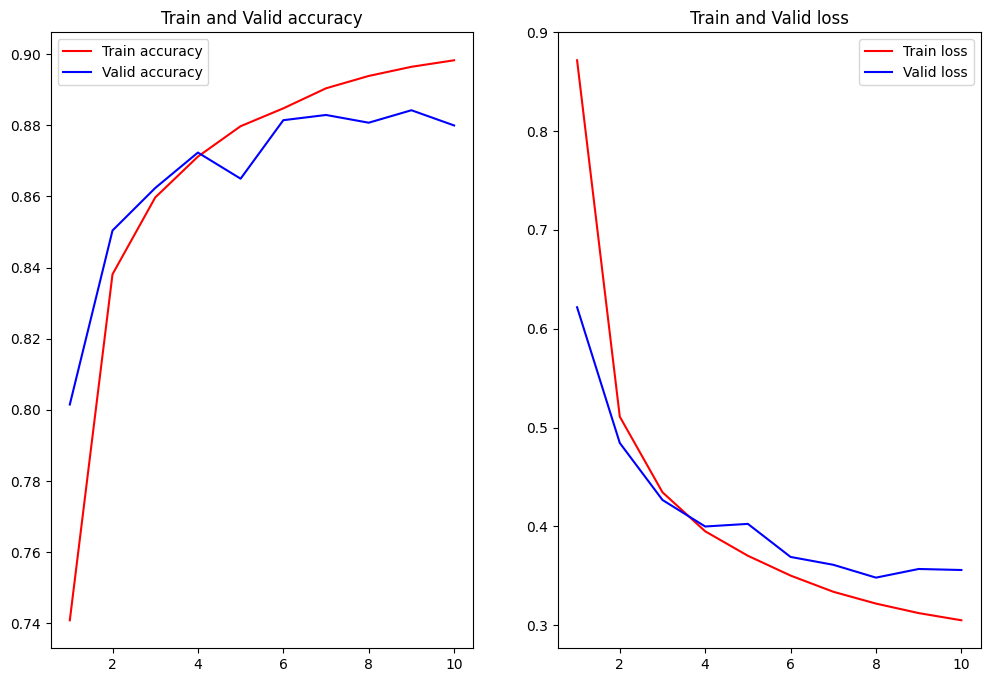

([0.871681138293143,
  0.5110420072445387,
  0.43447654126054147,
  0.39500151864356464,
  0.3702416445426199,
  0.3501911552532881,
  0.3338155885743257,
  0.32184860471586946,
  0.31222166089084974,
  0.30495597504439476],
 [0.7409049152757339,
  0.8381149279233127,
  0.8596868773189192,
  0.871168970088875,
  0.8797084653220383,
  0.8847219586297542,
  0.890352845715788,
  0.893824043883068,
  0.896395309122568,
  0.898228987462103],
 [0.6217576485935904,
  0.48439558438983255,
  0.4267121215095724,
  0.3998634473709025,
  0.4025091774416988,
  0.36905504346848383,
  0.36111908101102214,
  0.3481093405404549,
  0.3568679977115575,
  0.3558364272833507],
 [0.8015202642335586,
  0.8504054781805154,
  0.8623463066023015,
  0.8723039198600525,
  0.8649627044531798,
  0.8813968392029352,
  0.8828642272864372,
  0.8806913062346787,
  0.8841946593807262,
  0.8799186934355739])

In [15]:
train(batch_model, train_dataloader, valid_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=epochs)

## Dropout model

In [16]:
dropout_model = DropoutModel(input_channels=1, hidden_channels=10, output_shape=len(class_names)).to(device)
print(dropout_model)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(dropout_model.parameters(), lr=0.01)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
epochs = 10

DropoutModel(
  (convolutional_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (convolutional_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
<class 'kmnist_model.DropoutModel'> Train loss: 1.3353, Train accuracy: 0.5539


Training:  10%|█         | 1/10 [00:46<07:00, 46.68s/it]

<class 'kmnist_model.DropoutModel'> Valid loss: 0.7489, Valid accuracy: 0.7890
Epoch 2/10
<class 'kmnist_model.DropoutModel'> Train loss: 1.0087, Train accuracy: 0.6643


Training:  20%|██        | 2/10 [01:40<06:47, 50.93s/it]

<class 'kmnist_model.DropoutModel'> Valid loss: 0.6752, Valid accuracy: 0.8064
Epoch 3/10
<class 'kmnist_model.DropoutModel'> Train loss: 0.9383, Train accuracy: 0.6842


Training:  30%|███       | 3/10 [02:33<06:02, 51.80s/it]

<class 'kmnist_model.DropoutModel'> Valid loss: 0.6144, Valid accuracy: 0.8265
Epoch 4/10
<class 'kmnist_model.DropoutModel'> Train loss: 0.9047, Train accuracy: 0.6996


Training:  40%|████      | 4/10 [03:25<05:11, 51.88s/it]

<class 'kmnist_model.DropoutModel'> Valid loss: 0.5771, Valid accuracy: 0.8351
Epoch 5/10
<class 'kmnist_model.DropoutModel'> Train loss: 0.8739, Train accuracy: 0.7121


Training:  50%|█████     | 5/10 [04:16<04:17, 51.47s/it]

<class 'kmnist_model.DropoutModel'> Valid loss: 0.5665, Valid accuracy: 0.8385
Epoch 6/10
<class 'kmnist_model.DropoutModel'> Train loss: 0.8576, Train accuracy: 0.7164


Training:  60%|██████    | 6/10 [05:02<03:19, 49.79s/it]

<class 'kmnist_model.DropoutModel'> Valid loss: 0.5307, Valid accuracy: 0.8469
Epoch 7/10
<class 'kmnist_model.DropoutModel'> Train loss: 0.8427, Train accuracy: 0.7215


Training:  70%|███████   | 7/10 [05:50<02:27, 49.07s/it]

<class 'kmnist_model.DropoutModel'> Valid loss: 0.5296, Valid accuracy: 0.8507
Epoch 8/10
<class 'kmnist_model.DropoutModel'> Train loss: 0.8309, Train accuracy: 0.7243


Training:  80%|████████  | 8/10 [06:35<01:35, 47.91s/it]

<class 'kmnist_model.DropoutModel'> Valid loss: 0.5448, Valid accuracy: 0.8466
Epoch 9/10
<class 'kmnist_model.DropoutModel'> Train loss: 0.8123, Train accuracy: 0.7317


Training:  90%|█████████ | 9/10 [07:22<00:47, 47.42s/it]

<class 'kmnist_model.DropoutModel'> Valid loss: 0.5306, Valid accuracy: 0.8423
Epoch 10/10
<class 'kmnist_model.DropoutModel'> Train loss: 0.8088, Train accuracy: 0.7334


Training: 100%|██████████| 10/10 [08:07<00:00, 48.77s/it]

<class 'kmnist_model.DropoutModel'> Valid loss: 0.4833, Valid accuracy: 0.8629
Total training time: 487.75 seconds


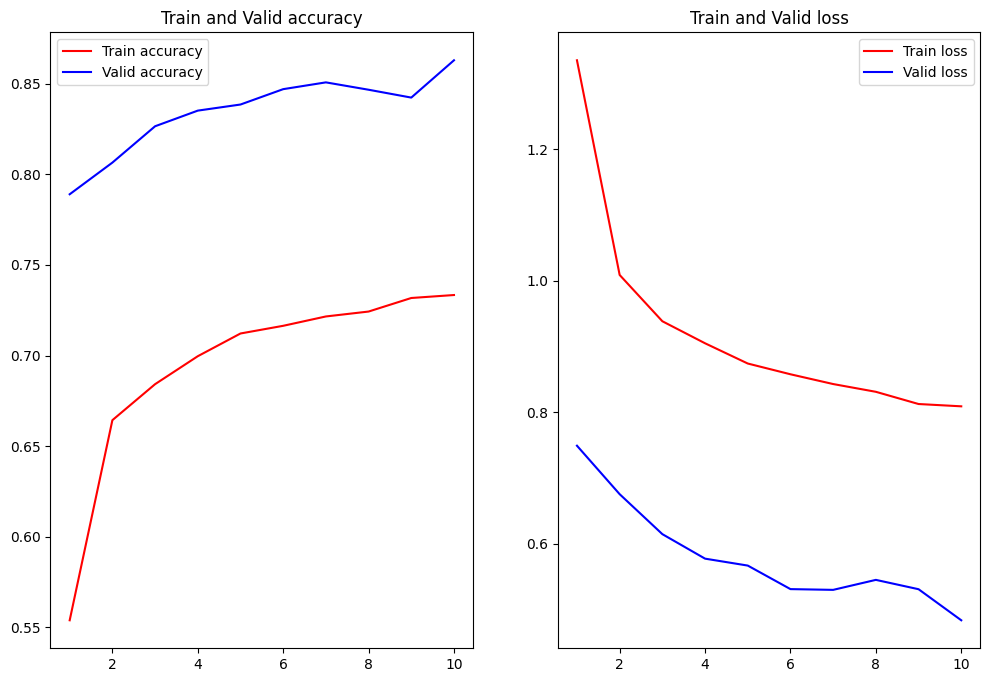

([1.335318360400514,
  1.0086842389579695,
  0.9382645325210209,
  0.9047456120292271,
  0.8739467730742165,
  0.8575922291344692,
  0.8427293540843238,
  0.8309276389462051,
  0.812333152287424,
  0.8088334474972187],
 [0.553924146270273,
  0.6643260294023132,
  0.6841841030068466,
  0.6996115168833688,
  0.7121484403481516,
  0.7163864665823169,
  0.7215446566570052,
  0.7242551066556668,
  0.7317313052578236,
  0.7333699755524961],
 [0.748910023966718,
  0.6751538754782218,
  0.6143549196024383,
  0.577075845618265,
  0.5665425712845927,
  0.5307272292434957,
  0.5295842573099714,
  0.5447902608384442,
  0.530573789971579,
  0.4833138625923001],
 [0.7889614056437889,
  0.8064328075727958,
  0.8264778661558212,
  0.8351087413224462,
  0.8384715698367761,
  0.8469498093866369,
  0.8506944202867691,
  0.8466289297965922,
  0.8422964353154139,
  0.862882646801633])

In [17]:
train(dropout_model, train_dataloader, valid_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=epochs)

## LeNet model

In [18]:
lenet_model = LeNetModel(input_channels=1, output_shape=len(class_names)).to(device)
print(lenet_model)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=0.005)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
epochs = 10

LeNetModel(
  (convolutional_block): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (fully_connected_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Tanh()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
<class 'kmnist_model.LeNetModel'> Train loss: 0.4049, Train accuracy: 0.8667


Training:  10%|█         | 1/10 [00:45<06:53, 45.91s/it]

<class 'kmnist_model.LeNetModel'> Valid loss: 0.3053, Valid accuracy: 0.9024
Epoch 2/10
<class 'kmnist_model.LeNetModel'> Train loss: 0.2409, Train accuracy: 0.9222


Training:  20%|██        | 2/10 [01:28<05:49, 43.73s/it]

<class 'kmnist_model.LeNetModel'> Valid loss: 0.2686, Valid accuracy: 0.9145
Epoch 3/10
<class 'kmnist_model.LeNetModel'> Train loss: 0.2079, Train accuracy: 0.9305


Training:  30%|███       | 3/10 [02:10<05:02, 43.18s/it]

<class 'kmnist_model.LeNetModel'> Valid loss: 0.2356, Valid accuracy: 0.9252
Epoch 4/10
<class 'kmnist_model.LeNetModel'> Train loss: 0.1899, Train accuracy: 0.9375


Training:  40%|████      | 4/10 [02:53<04:18, 43.07s/it]

<class 'kmnist_model.LeNetModel'> Valid loss: 0.2210, Valid accuracy: 0.9270
Epoch 5/10
<class 'kmnist_model.LeNetModel'> Train loss: 0.1867, Train accuracy: 0.9394


Training:  50%|█████     | 5/10 [03:36<03:35, 43.09s/it]

<class 'kmnist_model.LeNetModel'> Valid loss: 0.2134, Valid accuracy: 0.9311
Epoch 6/10
<class 'kmnist_model.LeNetModel'> Train loss: 0.1756, Train accuracy: 0.9425


Training:  60%|██████    | 6/10 [04:20<02:53, 43.27s/it]

<class 'kmnist_model.LeNetModel'> Valid loss: 0.2288, Valid accuracy: 0.9251
Epoch 7/10
<class 'kmnist_model.LeNetModel'> Train loss: 0.1702, Train accuracy: 0.9426


Training:  70%|███████   | 7/10 [05:04<02:11, 43.68s/it]

<class 'kmnist_model.LeNetModel'> Valid loss: 0.2092, Valid accuracy: 0.9326
Epoch 8/10
<class 'kmnist_model.LeNetModel'> Train loss: 0.1661, Train accuracy: 0.9459


Training:  80%|████████  | 8/10 [05:48<01:27, 43.61s/it]

<class 'kmnist_model.LeNetModel'> Valid loss: 0.2041, Valid accuracy: 0.9342
Epoch 9/10
<class 'kmnist_model.LeNetModel'> Train loss: 0.1604, Train accuracy: 0.9458


Training:  90%|█████████ | 9/10 [06:30<00:43, 43.31s/it]

<class 'kmnist_model.LeNetModel'> Valid loss: 0.1918, Valid accuracy: 0.9411
Epoch 10/10
<class 'kmnist_model.LeNetModel'> Train loss: 0.1634, Train accuracy: 0.9452


Training: 100%|██████████| 10/10 [07:14<00:00, 43.45s/it]

<class 'kmnist_model.LeNetModel'> Valid loss: 0.2032, Valid accuracy: 0.9329
Total training time: 434.51 seconds


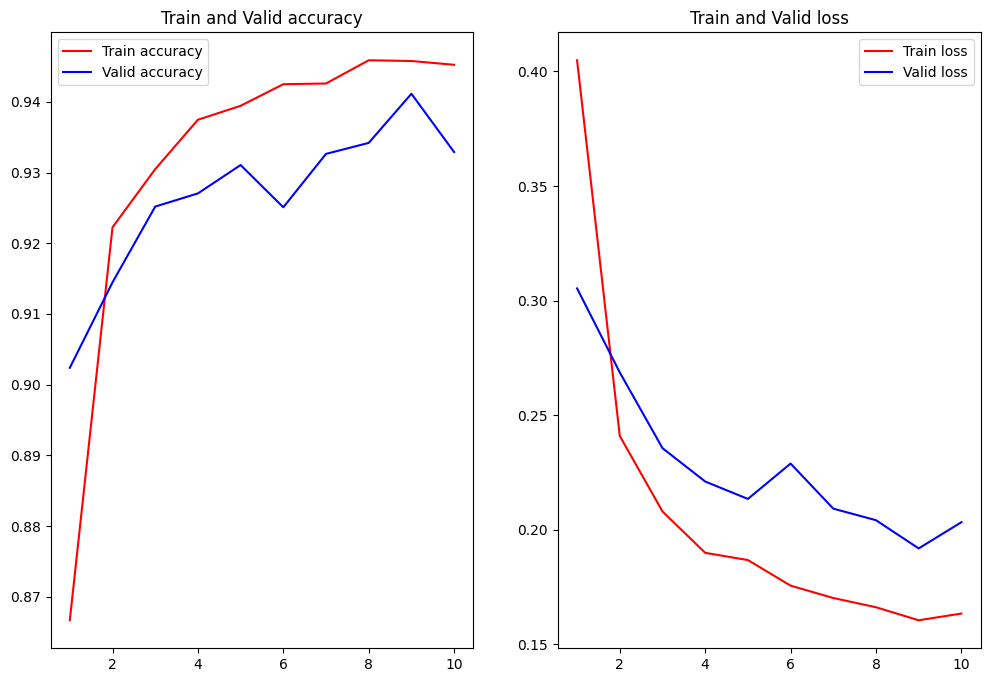

([0.40486855778728575,
  0.24088827116860395,
  0.20792310622421942,
  0.1898793862876526,
  0.18671857211469894,
  0.17555909069682946,
  0.17015729845125563,
  0.16612304580235376,
  0.1604367426724617,
  0.1633707292616772],
 [0.866664159072508,
  0.9222488753165529,
  0.9304753456262396,
  0.9374611793040332,
  0.9394346576626018,
  0.942489438474515,
  0.9425895217822471,
  0.9458744311512303,
  0.9457721546320368,
  0.945234677436886],
 [0.30529719344555695,
  0.26861012858931915,
  0.2355645872665788,
  0.22100547230487616,
  0.2133973221695614,
  0.2288467484158447,
  0.20916664533091717,
  0.20411790946823316,
  0.1917957078360578,
  0.20324286446969597],
 [0.9023779350667661,
  0.914466905212063,
  0.9251806349940995,
  0.9270418439047192,
  0.9310577019677891,
  0.9250822313315503,
  0.9326346455095501,
  0.9341874606244505,
  0.9411381012180098,
  0.932894514548821])

In [19]:
train(lenet_model, train_dataloader, valid_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=epochs)

## ConvNet VGG16 (Модификований)

In [26]:
convnet_model = ConvNetModel(input_channels=1, output_shape=len(class_names)).to(device)
print(convnet_model)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(convnet_model.parameters(), lr=0.001)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
epochs = 10

ConvNetModel(
  (convolutional_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (convolutional_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
<class 'kmnist_model.ConvNetModel'> Train loss: 0.2406, Train accuracy: 0.9185


Training:  10%|█         | 1/10 [00:51<07:44, 51.57s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0954, Valid accuracy: 0.9675
Epoch 2/10
<class 'kmnist_model.ConvNetModel'> Train loss: 0.0822, Train accuracy: 0.9720


Training:  20%|██        | 2/10 [01:41<06:45, 50.70s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0557, Valid accuracy: 0.9813
Epoch 3/10
<class 'kmnist_model.ConvNetModel'> Train loss: 0.0607, Train accuracy: 0.9795


Training:  30%|███       | 3/10 [02:31<05:51, 50.23s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0768, Valid accuracy: 0.9759
Epoch 4/10
<class 'kmnist_model.ConvNetModel'> Train loss: 0.0500, Train accuracy: 0.9837


Training:  40%|████      | 4/10 [03:20<04:59, 49.84s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0400, Valid accuracy: 0.9868
Epoch 5/10
<class 'kmnist_model.ConvNetModel'> Train loss: 0.0381, Train accuracy: 0.9865


Training:  50%|█████     | 5/10 [04:09<04:07, 49.44s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0345, Valid accuracy: 0.9884
Epoch 6/10
<class 'kmnist_model.ConvNetModel'> Train loss: 0.0337, Train accuracy: 0.9879


Training:  60%|██████    | 6/10 [04:58<03:17, 49.46s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0391, Valid accuracy: 0.9864
Epoch 7/10
<class 'kmnist_model.ConvNetModel'> Train loss: 0.0292, Train accuracy: 0.9902


Training:  70%|███████   | 7/10 [05:47<02:27, 49.33s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0324, Valid accuracy: 0.9897
Epoch 8/10
<class 'kmnist_model.ConvNetModel'> Train loss: 0.0246, Train accuracy: 0.9919


Training:  80%|████████  | 8/10 [06:37<01:38, 49.29s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0409, Valid accuracy: 0.9884
Epoch 9/10
<class 'kmnist_model.ConvNetModel'> Train loss: 0.0236, Train accuracy: 0.9920


Training:  90%|█████████ | 9/10 [07:25<00:49, 49.10s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0394, Valid accuracy: 0.9879
Epoch 10/10
<class 'kmnist_model.ConvNetModel'> Train loss: 0.0215, Train accuracy: 0.9931


Training: 100%|██████████| 10/10 [08:16<00:00, 49.68s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0286, Valid accuracy: 0.9920
Total training time: 496.83 seconds


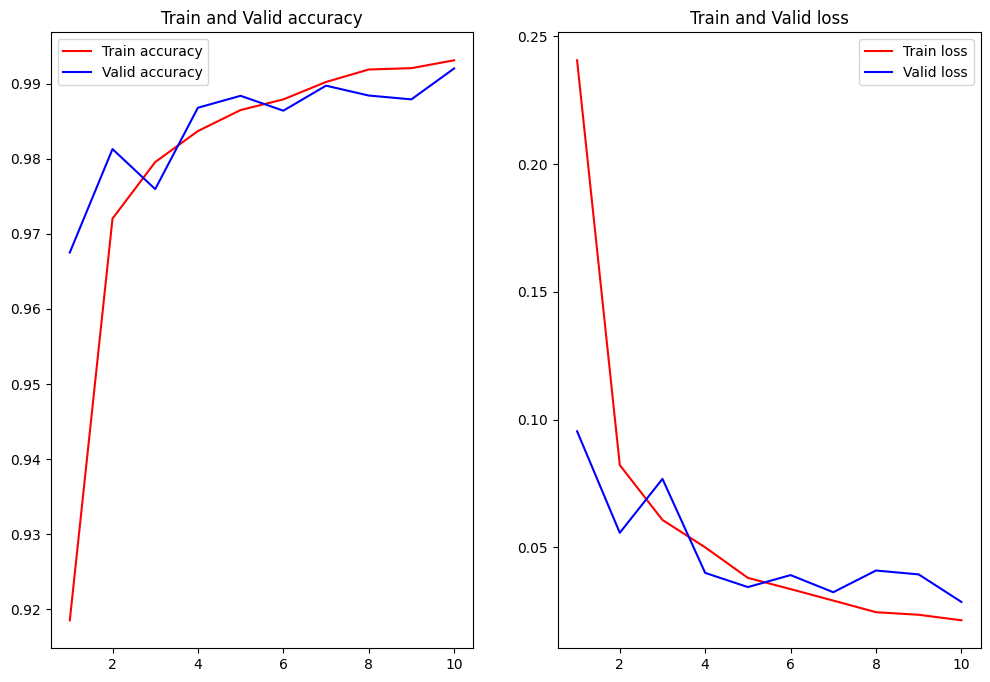

([0.24059387604292068,
  0.08220999592366206,
  0.06070786202097131,
  0.050009932972820595,
  0.038056080539363546,
  0.033663829910602926,
  0.029169551126598442,
  0.024626476712103218,
  0.0236141194376515,
  0.021464605565401838],
 [0.91853813567694,
  0.9720197067422381,
  0.9795419478371543,
  0.9836701268829494,
  0.9864675174774199,
  0.9878841295454835,
  0.990201005191827,
  0.9918647816700525,
  0.9920420201409933,
  0.9930930933485372],
 [0.0954394463049513,
  0.055691923999067666,
  0.07680413764490276,
  0.0400053121881434,
  0.034456717118076234,
  0.03914218112736291,
  0.032442781583977585,
  0.040935990611702514,
  0.03941114034067706,
  0.02864699861603551],
 [0.9675031270420849,
  0.9812710647905425,
  0.9759409397946558,
  0.9867757656396071,
  0.9883632388403407,
  0.9863798416806285,
  0.9897125622131646,
  0.9884005914379269,
  0.9878882173965834,
  0.9920059103134264])

In [27]:
train(convnet_model, train_dataloader, valid_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=epochs)

Найкраща та найшвидша модель VGG16

# Роблю предікти та будую графіки

In [28]:
pred_probs = []
convnet_model.eval()
with torch.inference_mode():
    for X, y in test_data:
        X = torch.unsqueeze(X, dim=0).to(device) 
        pred_logit = convnet_model(X)
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
        predicted_class = pred_prob.argmax().item()
        pred_probs.append(predicted_class)
print(pred_probs[:10])
print(test_data.targets[:10])


[2, 9, 3, 8, 3, 3, 8, 3, 2, 5]
tensor([2, 9, 3, 8, 3, 3, 8, 3, 2, 5])


In [32]:
true_values = test_data.targets
pred_values = []
for X, y in test_data:
    pred = predict(X, convnet_model, device).cpu().unsqueeze(0)
    pred_values.append(pred)
pred_values = torch.cat(pred_values)
compar_list = [a == b for a, b in zip(true_values, pred_values)]
print(f'{sum(compar_list)}/{len(compar_list)}')

9719/10000


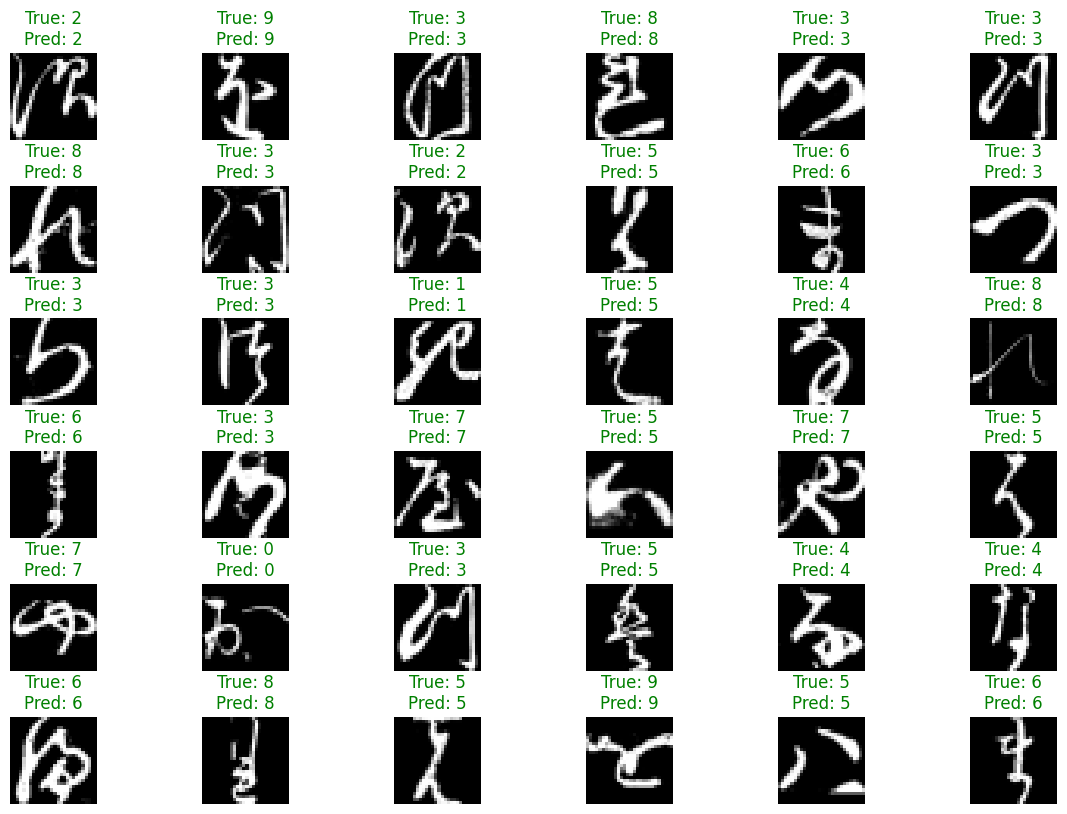

In [33]:
rows = 6
columns = 6

fig, axs = plt.subplots(rows, columns, figsize=(12, 8))
for i in range(rows):
    for j in range(columns):
        idx = i * rows + j
        axs[i, j].imshow(test_data.data[idx].squeeze(), cmap='gray')
        text = f'True: {test_data.targets[idx]}\nPred: {pred_values[idx]}'
        if true_values[idx] == pred_values[idx]:
            axs[i, j].set_title(text, color='green')
        else:
            axs[i, j].set_title(text, color='red')
        axs[i, j].axis('off')   
plt.tight_layout(pad=0.2)

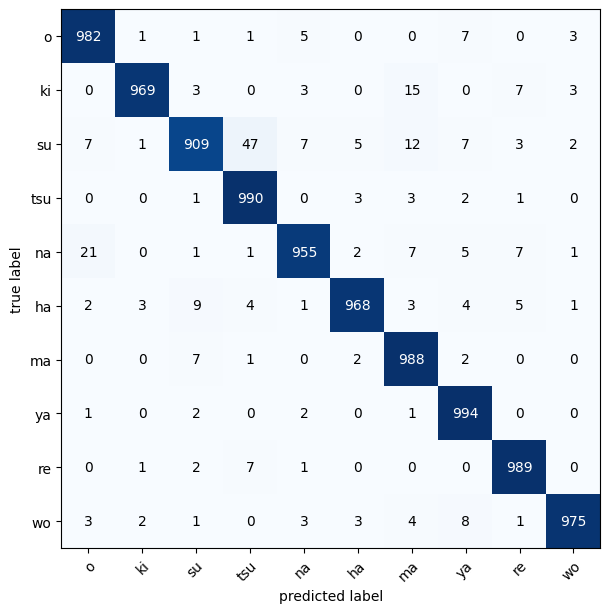

In [34]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=pred_values,
                         target=true_values)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

# Висновок

1. ConvNet супер пупер класна модель для цієї задачі та досить швидко навчається не дивлячись на більш складну модель
2. Не вчити японську мову